# Drift–Diffusion Processes and Langevin Monte Carlo

This notebook illustrates 1. drift–diffusion processes in one dimension using simple simulations:

1.1. Pure diffusion (no drift) \
1.2. Pure drift (no diffusion) \
1.3. Drift + diffusion together \
1.4. Langevin diffusion view (drift from a potential) \
1.5. Monte Carlo / law-of-large-numbers view via many trajectories I am running a few minutes late; my previous meeting is running over.

It also presents 2. Bayesian Logistic Regression with Random-Walk MH, ULA, and MALA



In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

rng = np.random.default_rng(0)

## Utility: simulate 1D drift–diffusion

We simulate the stochastic differential equation (SDE)

$ dX_t = \mu\,dt + \sigma\,dW_t$

by an Euler–Maruyama discretization:

$ X_{k+1} = X_k + \mu \Delta t + \sigma \sqrt{\Delta t} Z_k, \quad Z_k \sim \mathcal{N}(0, 1). $

The function below will be reused across experiments.

In [3]:
def simulate_paths(mu, sigma, x0=0.0, T=5.0, dt=0.01, n_paths=1, rng=None):
    """Simulate n_paths of 1D drift–diffusion:
        dX_t = mu dt + sigma dW_t
    Returns times (t) and array X of shape (n_paths, n_steps).
    """
    if rng is None:
        rng = np.random.default_rng()
    n_steps = int(T / dt) + 1
    t = np.linspace(0.0, T, n_steps)
    X = np.zeros((n_paths, n_steps))
    X[:, 0] = x0
    # pre-generate noise
    dW = rng.normal(loc=0.0, scale=np.sqrt(dt), size=(n_paths, n_steps-1))
    for k in range(n_steps - 1):
        X[:, k+1] = X[:, k] + mu * dt + sigma * dW[:, k]
    return t, X

## 1.1. Pure diffusion (no drift)

Set $\mu = 0$. The process

$$ dX_t = \sigma\,dW_t $$

is standard Brownian motion scaled by $\sigma$: the position wanders randomly with no preferred direction.

We will:

- Plot a few sample paths versus time.
- Plot histograms of $X_t$ at different times to see how the distribution spreads out while staying centered at 0.

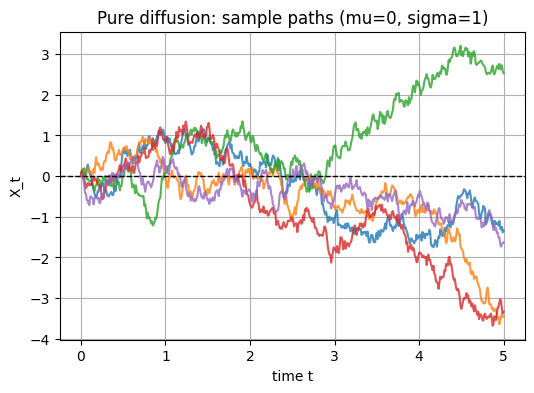

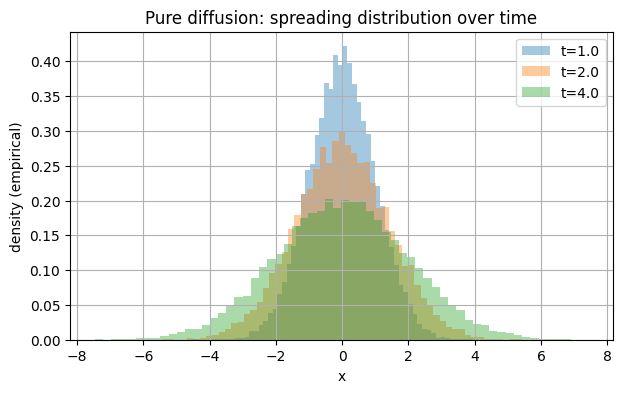

In [4]:
# Parameters
mu = 0.0
sigma = 1.0
T = 5.0
dt = 0.01
n_paths = 5

# Simulate
t, X = simulate_paths(mu, sigma, x0=0.0, T=T, dt=dt, n_paths=n_paths, rng=rng)

# Plot sample paths
plt.figure()
for i in range(n_paths):
    plt.plot(t, X[i], alpha=0.8)
plt.axhline(0, color='k', linewidth=1, linestyle='--')
plt.title('Pure diffusion: sample paths (mu=0, sigma=1)')
plt.xlabel('time t')
plt.ylabel('X_t')
plt.show()

# Distribution snapshots at selected times
snap_times = [1.0, 2.0, 4.0]
indices = [np.argmin(np.abs(t - s)) for s in snap_times]

# Simulate many paths for good histograms
_, X_many = simulate_paths(mu, sigma, x0=0.0, T=T, dt=dt, n_paths=20000, rng=rng)

plt.figure(figsize=(7, 4))
for s, idx in zip(snap_times, indices):
    plt.hist(X_many[:, idx], bins=60, density=True, alpha=0.4, label=f't={s:.1f}')
plt.title('Pure diffusion: spreading distribution over time')
plt.xlabel('x')
plt.ylabel('density (empirical)')
plt.legend()
plt.show()

## 1.2. Pure drift (no diffusion)

Set $\sigma = 0$. The process

$$ dX_t = \mu\,dt $$

has the deterministic solution $X_t = X_0 + \mu t$: a straight line. There is no randomness.

We will:

- Plot a few "paths" (they are identical) for $\mu = 1$.
- Note that the distribution does **not** spread; it just translates.

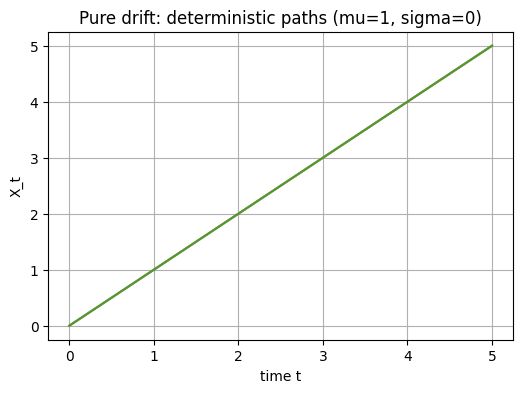

In [5]:
mu = 1.0
sigma = 0.0
T = 5.0
dt = 0.01
n_paths = 3

# Simulate
t, X = simulate_paths(mu, sigma, x0=0.0, T=T, dt=dt, n_paths=n_paths, rng=rng)

plt.figure()
for i in range(n_paths):
    plt.plot(t, X[i], alpha=0.8)
plt.title('Pure drift: deterministic paths (mu=1, sigma=0)')
plt.xlabel('time t')
plt.ylabel('X_t')
plt.show()

## 1.3. Drift + diffusion together

Now combine both terms:

$$ dX_t = \mu\,dt + \sigma\,dW_t. $$

We choose $\mu = 0.5$ and $\sigma = 1$, so the trajectories trend upward on average, but still exhibit random fluctuations.

We will:

- Plot multiple paths to see the noisy upward trend.
- Show histograms of $X_t$ at several times; the mean moves linearly while the variance grows like $\sigma^2 t$.

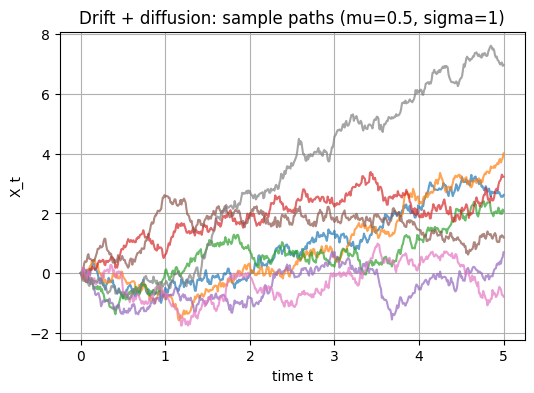

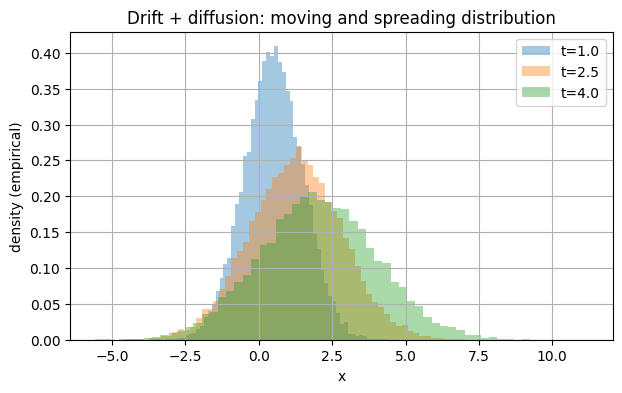

In [6]:
mu = 0.5
sigma = 1.0
T = 5.0
dt = 0.01
n_paths = 8

# Sample paths
t, X = simulate_paths(mu, sigma, x0=0.0, T=T, dt=dt, n_paths=n_paths, rng=rng)

plt.figure()
for i in range(n_paths):
    plt.plot(t, X[i], alpha=0.7)
plt.title('Drift + diffusion: sample paths (mu=0.5, sigma=1)')
plt.xlabel('time t')
plt.ylabel('X_t')
plt.show()

# Distribution snapshots
snap_times = [1.0, 2.5, 4.0]
indices = [np.argmin(np.abs(t - s)) for s in snap_times]

_, X_many = simulate_paths(mu, sigma, x0=0.0, T=T, dt=dt, n_paths=20000, rng=rng)

plt.figure(figsize=(7, 4))
for s, idx in zip(snap_times, indices):
    plt.hist(X_many[:, idx], bins=60, density=True, alpha=0.4, label=f't={s:.1f}')
plt.title('Drift + diffusion: moving and spreading distribution')
plt.xlabel('x')
plt.ylabel('density (empirical)')
plt.legend()
plt.show()

## Drift–diffusion in a simple decision model

Here we illustrate the **drift–diffusion model (DDM)** idea from decision making:

$$ dX_t = v\,dt + \sigma\,dW_t, $$

with absorbing boundaries at $+a$ and $-a$. A path hitting:

- $+a$ corresponds to choosing option 1
- $-a$ corresponds to choosing option 2

The drift $v$ controls bias toward one option, and the noise $\sigma$ controls variability in choices and reaction times.

We simulate a small number of paths and show where they terminate relative to the bounds.

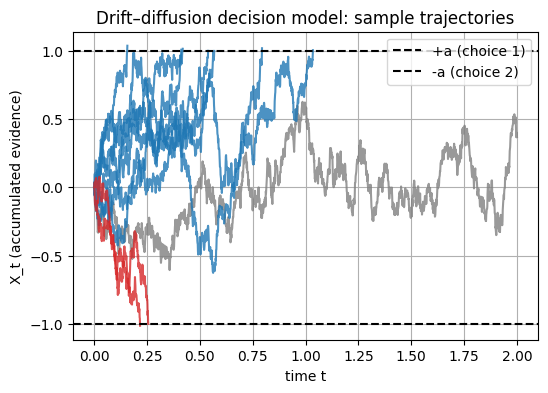

In [7]:
def simulate_ddm(v, sigma, a=1.0, x0=0.0, dt=0.001, T_max=3.0, rng=None):
    """Simulate a single DDM trajectory until hitting +a or -a, or T_max.
    Returns t_path, x_path, decision (+1, -1, or 0 if no decision by T_max).
    """
    if rng is None:
        rng = np.random.default_rng()
    n_steps = int(T_max / dt) + 1
    t = np.linspace(0.0, T_max, n_steps)
    x = np.empty(n_steps)
    x[0] = x0
    dW = rng.normal(scale=np.sqrt(dt), size=n_steps-1)
    decision = 0
    last_idx = n_steps - 1
    for k in range(n_steps - 1):
        x[k+1] = x[k] + v * dt + sigma * dW[k]
        if x[k+1] >= a:
            decision = +1
            last_idx = k + 1
            break
        if x[k+1] <= -a:
            decision = -1
            last_idx = k + 1
            break
    return t[: last_idx+1], x[: last_idx+1], decision

# Parameters
v = 0.4   # drift toward +a
sigma = 1.0
a = 1.0

n_paths = 10
plt.figure()
for i in range(n_paths):
    t_path, x_path, dec = simulate_ddm(v, sigma, a=a, dt=0.001, T_max=2.0, rng=rng)
    color = 'tab:blue' if dec == +1 else ('tab:red' if dec == -1 else 'gray')
    plt.plot(t_path, x_path, color=color, alpha=0.8)

plt.axhline(a, color='k', linestyle='--', label='+a (choice 1)')
plt.axhline(-a, color='k', linestyle='--', label='-a (choice 2)')
plt.title('Drift–diffusion decision model: sample trajectories')
plt.xlabel('time t')
plt.ylabel('X_t (accumulated evidence)')
plt.legend()
plt.show()

## Langevin diffusion as drift from a potential

In Langevin dynamics, drift is given by the gradient of the log target density. In 1D this is

$$ dX_t = \tfrac{1}{2} \nabla \log \pi(X_t)\,dt + dW_t. $$

Here we take a simple **double-well potential**:

- Potential: $ U(x) = \tfrac{1}{4} x^4 - \tfrac{1}{2} x^2 $
- Target density: $ \pi(x) \propto e^{-U(x)} $
- Drift: $ b(x) = -\tfrac{1}{2} U'(x) $

This gives two modes (at the wells) and a low-density barrier in between.

We simulate a few Langevin trajectories and see how they tend to spend more time near the wells.

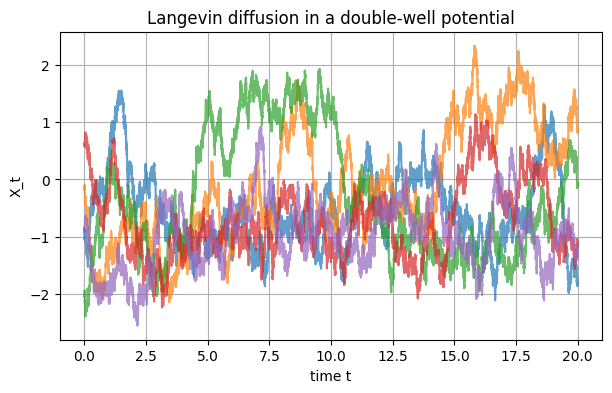

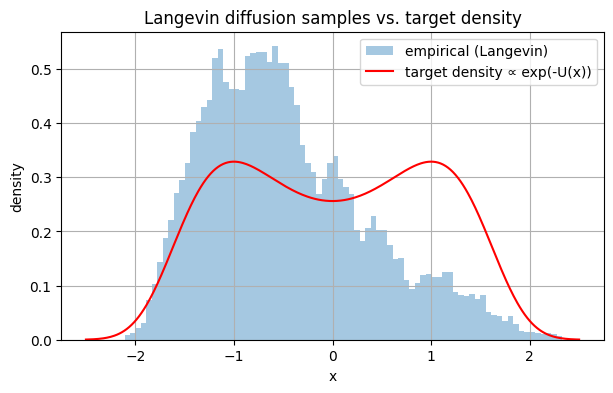

In [8]:
def potential_U(x):
    return 0.25 * x**4 - 0.5 * x**2

def grad_log_pi(x):
    # log pi(x) = -U(x) + const
    # grad log pi = -U'(x)
    return -(x**3 - x)

# Langevin parameters
T = 20.0
dt = 0.001
n_paths = 5

n_steps = int(T / dt) + 1
t = np.linspace(0.0, T, n_steps)

X = np.zeros((n_paths, n_steps))
X[:, 0] = rng.normal(0.0, 1.0, size=n_paths)

for k in range(n_steps - 1):
    x_curr = X[:, k]
    drift = 0.5 * grad_log_pi(x_curr)
    dW = rng.normal(scale=np.sqrt(dt), size=n_paths)
    X[:, k+1] = x_curr + drift * dt + dW

# Plot a few trajectories
plt.figure(figsize=(7, 4))
for i in range(n_paths):
    plt.plot(t, X[i], alpha=0.7)
plt.title('Langevin diffusion in a double-well potential')
plt.xlabel('time t')
plt.ylabel('X_t')
plt.show()

# Plot stationary-like histogram vs potential
# Use last half of samples from all paths as approximate stationary sample
burn_idx = n_steps // 2
samples = X[:, burn_idx:].ravel()

xs = np.linspace(-2.5, 2.5, 400)
U_vals = potential_U(xs)
pi_unnorm = np.exp(-U_vals)
pi_unnorm /= np.trapezoid(pi_unnorm, xs)

plt.figure(figsize=(7, 4))
plt.hist(samples, bins=80, density=True, alpha=0.4, label='empirical (Langevin)')
plt.plot(xs, pi_unnorm, 'r-', label='target density ∝ exp(-U(x))')
plt.title('Langevin diffusion samples vs. target density')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()


### 1.4 Langevin (Ornstein–Uhlenbeck) sampling from a Gaussian

We simulate the stochastic differential equation (SDE)

$ dX_t = -\tfrac12 X_t\,dt + dW_t, $

where $W_t$ is standard Brownian motion.  
This is the **Ornstein–Uhlenbeck process**, a classic mean-reverting diffusion.

---

#### Why does this sample from $\mathcal{N}(0,1)$?

A general OU process is

$ dX_t = -\theta X_t\,dt + \sigma\, dW_t. $

It has a stationary (long-run) distribution

$ X_\infty \sim \mathcal{N}\!\Bigl(0,\ \frac{\sigma^2}{2\theta}\Bigr). $

Here, $\theta = 0.5$ and $\sigma = 1$. So

$ \mathrm{Var}(X_\infty) = \frac{1^2}{2 \cdot 0.5} = 1, $

meaning the stationary distribution is exactly

$ X_\infty \sim \mathcal{N}(0,1). $

So if we run the simulation long enough (large $T$), the distribution of $X_t$ approaches $\mathcal{N}(0,1)$.

---

#### What does the code do computationally?

We discretize the SDE using Euler–Maruyama:

$ X_{k+1} = X_k + (-0.5 X_k)\,\Delta t + \sqrt{\Delta t}\, \xi_k,\quad \xi_k\sim\mathcal{N}(0,1). $

- The term $-0.5 X_k$ pulls the process back toward 0 (mean reversion).
- The noise term $\sqrt{\Delta t}\,\xi_k$ prevents collapse and spreads mass.

The result is a **discrete-time Markov chain** that approximates the OU diffusion.


Generating Step 5: Langevin Sampling...


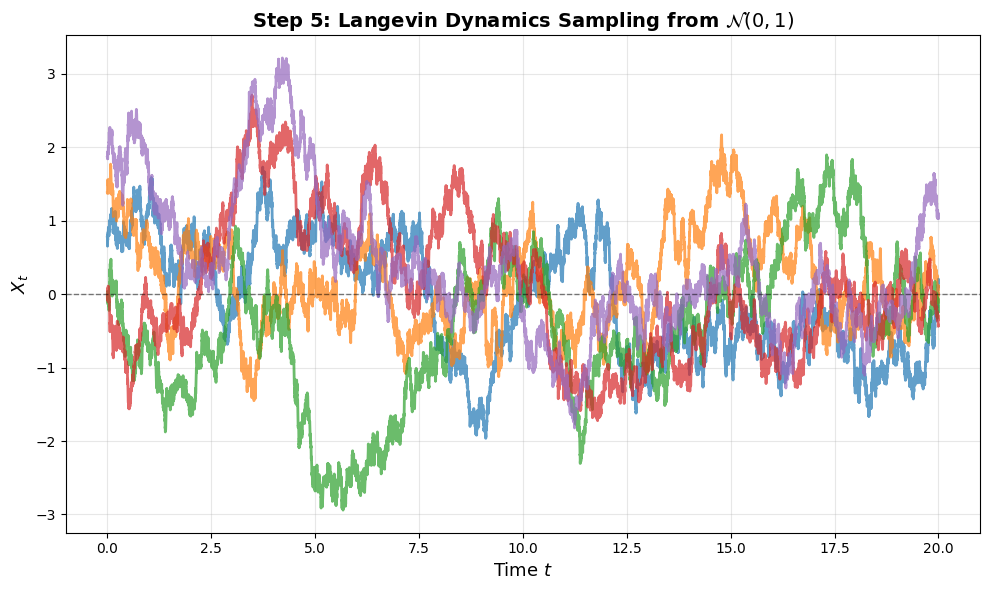

In [26]:
#============================================================================
# STEP 5: LANGEVIN SAMPLING FROM GAUSSIAN
# ============================================================================

print("Generating Step 5: Langevin Sampling...")

def langevin_sample(T=20.0, dt=0.001, n_paths=5, rng=None):
    """Sample from standard Gaussian using Langevin: dX_t = -0.5*X_t*dt + dW_t"""
    if rng is None:
        rng = np.random.default_rng()
    n_steps = int(T / dt) + 1
    t = np.linspace(0.0, T, n_steps)
    X = np.zeros((n_paths, n_steps))
    X[:, 0] = rng.normal(0.0, 1.0, size=n_paths)

    for k in range(n_steps - 1):
        x_curr = X[:, k]
        drift = -0.5 * x_curr  # gradient of -log N(0,1) / 2
        #drift = -(x_curr-2)/6  # sample from N(2,3)
        dW = rng.normal(scale=np.sqrt(dt), size=n_paths)
        X[:, k+1] = x_curr + drift * dt + dW
    return t, X

t_lang, X_lang = langevin_sample(T=20.0, dt=0.001, n_paths=5, rng=rng)

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(5):
    ax.plot(t_lang, X_lang[i], alpha=0.7, linewidth=2)
ax.axhline(0, color='k', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Time $t$', fontsize=13)
ax.set_ylabel('$X_t$', fontsize=13)
ax.set_title('Step 5: Langevin Dynamics Sampling from $\\mathcal{N}(0,1)$',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()

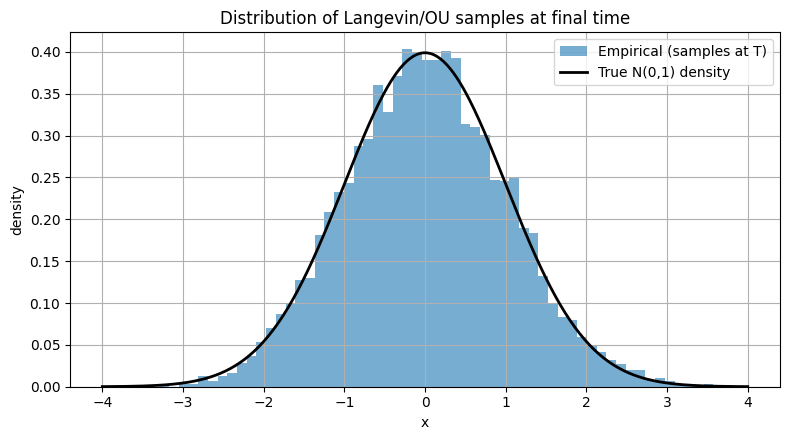

Empirical mean: 0.014861435773641367
Empirical var : 1.0169149679412577


In [27]:

import numpy as np
import matplotlib.pyplot as plt

# Run many paths, keep only final values
t_lang, X_lang = langevin_sample(T=20.0, dt=0.001, n_paths=5000, rng=rng)
samples = X_lang[:, -1]  # X_T across many independent paths

# Plot histogram vs true N(0,1)
xs = np.linspace(-4, 4, 400)
true_pdf = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * xs**2)  # sample from N(0,1)
#true_pdf = (1/np.sqrt(2*np.pi*3)) * np.exp(-0.5 * (xs-2)**2/3)  # sample from N(2,3)

plt.figure(figsize=(8,4.5))
plt.hist(samples, bins=60, density=True, alpha=0.6, label='Empirical (samples at T)')
plt.plot(xs, true_pdf, 'k-', lw=2, label='True N(0,1) density')
plt.title('Distribution of Langevin/OU samples at final time')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.tight_layout()
plt.show()

print("Empirical mean:", samples.mean())
print("Empirical var :", samples.var())


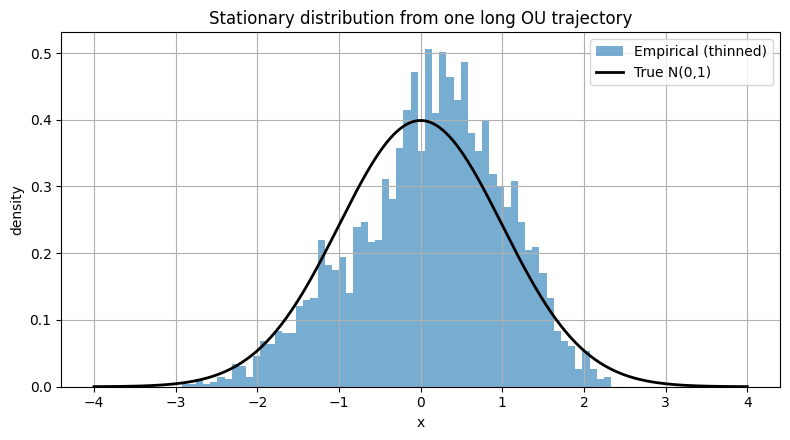

In [28]:

# One long path, drop burn-in
t_lang, X_lang = langevin_sample(T=200.0, dt=0.001, n_paths=1, rng=rng)
x = X_lang[0]
burn = int(50.0 / 0.001)   # burn in first 50 time units
thin = 50                  # thin to reduce autocorrelation
samples = x[burn::thin]

xs = np.linspace(-4, 4, 400)
true_pdf = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * xs**2)

plt.figure(figsize=(8,4.5))
plt.hist(samples, bins=60, density=True, alpha=0.6, label='Empirical (thinned)')
plt.plot(xs, true_pdf, 'k-', lw=2, label='True N(0,1)')
plt.title('Stationary distribution from one long OU trajectory')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.tight_layout()
plt.show()



## Step 1.5 — Monte Carlo Convergence (LLN)

We simulate a drift–diffusion process (Brownian motion with drift)

$
dX_t = \mu\,dt + \sigma\, dW_t,\qquad X_0=x_0
$

For this model,

$
X_T = x_0 + \mu T + \sigma W_T \quad\Rightarrow\quad \mathbb{E}[X_T]=x_0+\mu T.
$

### Monte Carlo estimator
For each number of trajectories \(n\), we simulate \(n\) independent terminal values
$
X_T^{(1)},\dots,X_T^{(n)}
$
and estimate
$
\widehat{\mathbb{E}[X_T]}=\frac{1}{n}\sum_{i=1}^n X_T^{(i)}.
$

As $n\to\infty$, the estimator converges to the true mean (Law of Large Numbers).
The typical error decreases like $1/\sqrt{n}$, which is why we test increasing sample sizes and plot the estimate versus $n$ (log scale).



Generating Step 6: Monte Carlo Convergence...

✓ All figures generated successfully!
Files created:
  - fig_step1_paths.pdf
  - fig_step1_dist.pdf
  - fig_step2_paths.pdf
  - fig_step3_paths.pdf
  - fig_step3_dist.pdf
  - fig_step4_ddm.pdf
  - fig_step5_traj.pdf
  - fig_step5_hist.pdf
  - fig_step6_convergence.pdf

Place all PDF files in the same directory as drift_diffusion_slides.tex
Then compile with: pdflatex drift_diffusion_slides.tex


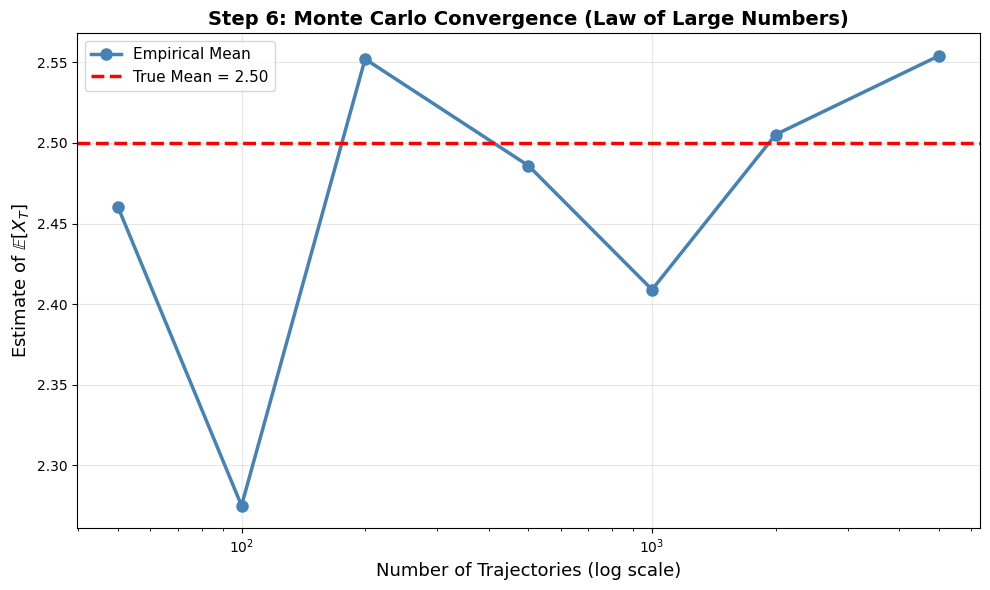

In [12]:
# ============================================================================
# STEP 6: MONTE CARLO CONVERGENCE
# ============================================================================

print("Generating Step 6: Monte Carlo Convergence...")

mu = 0.5
sigma = 1.0
T = 5.0
dt = 0.01
x0 = 0.0
true_mean = x0 + mu * T  # E[X_T] = 2.5

n_list = [50, 100, 200, 500, 1000, 2000, 5000]
estimates = []

for n_paths in n_list:
    _, X = simulate_paths(mu, sigma, x0=x0, T=T, dt=dt, n_paths=n_paths, rng=rng)
    est = X[:, -1].mean()
    estimates.append(est)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_list, estimates, 'o-', linewidth=2.5, markersize=8, label='Empirical Mean', color='steelblue')
ax.axhline(true_mean, color='r', linestyle='--', linewidth=2.5, label=f'True Mean = {true_mean:.2f}')
ax.set_xscale('log')
ax.set_xlabel('Number of Trajectories (log scale)', fontsize=13)
ax.set_ylabel('Estimate of $\\mathbb{E}[X_T]$', fontsize=13)
ax.set_title('Step 6: Monte Carlo Convergence (Law of Large Numbers)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()


print("\n✓ All figures generated successfully!")
print("Files created:")
print("  - fig_step1_paths.pdf")
print("  - fig_step1_dist.pdf")
print("  - fig_step2_paths.pdf")
print("  - fig_step3_paths.pdf")
print("  - fig_step3_dist.pdf")
print("  - fig_step4_ddm.pdf")
print("  - fig_step5_traj.pdf")
print("  - fig_step5_hist.pdf")
print("  - fig_step6_convergence.pdf")
print("\nPlace all PDF files in the same directory as drift_diffusion_slides.tex")
print("Then compile with: pdflatex drift_diffusion_slides.tex")

## Using ULA and MALA to sample from $ U(x) = \tfrac{1}{4} x^4 - \tfrac{1}{2} x^2 $



In [13]:
import numpy as np
import matplotlib.pyplot as plt

def potential_U(x):
    """Double-well potential"""
    return 0.25*x**4 - 0.5*x**2

def grad_U(x):
    """Gradient of potential"""
    return x**3 - x

def ula_step(x, dt=0.01, rng=None):
    """Unadjusted Langevin step"""
    if rng is None: rng = np.random.default_rng()
    drift = -0.5 * grad_U(x)
    noise = rng.normal(0, np.sqrt(dt))
    return x + drift * dt + noise

def mala_proposal(x_curr, dt=0.01, rng=None):
    """MALA proposal"""
    if rng is None: rng = np.random.default_rng()
    drift = -0.5 * grad_U(x_curr)
    noise = rng.normal(0, np.sqrt(dt))
    x_prop = x_curr + drift * dt + noise
    return x_prop

def mala_accept_prob(x_curr, x_prop, dt):
    """MALA acceptance probability"""
    U_curr = potential_U(x_curr)
    U_prop = potential_U(x_prop)
    # Metropolis-Hastings ratio (proposal is symmetric)
    return np.exp(U_curr - U_prop)

# Simulate trajectories
def simulate_langevin(n_steps=5000, dt=0.01, method='ula'):
    x = np.zeros(n_steps)
    x[0] = 1.5  # Start away from modes

    for k in range(1, n_steps):
        if method == 'ula':
            x[k] = ula_step(x[k-1], dt)
        elif method == 'mala':
            x_prop = mala_proposal(x[k-1], dt)
            alpha = mala_accept_prob(x[k-1], x_prop, dt)
            if np.random.rand() < alpha:
                x[k] = x_prop
            else:
                x[k] = x[k-1]

    return x


/tmp/ipython-input-4191326202.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  target /= np.trapz(target, xs)


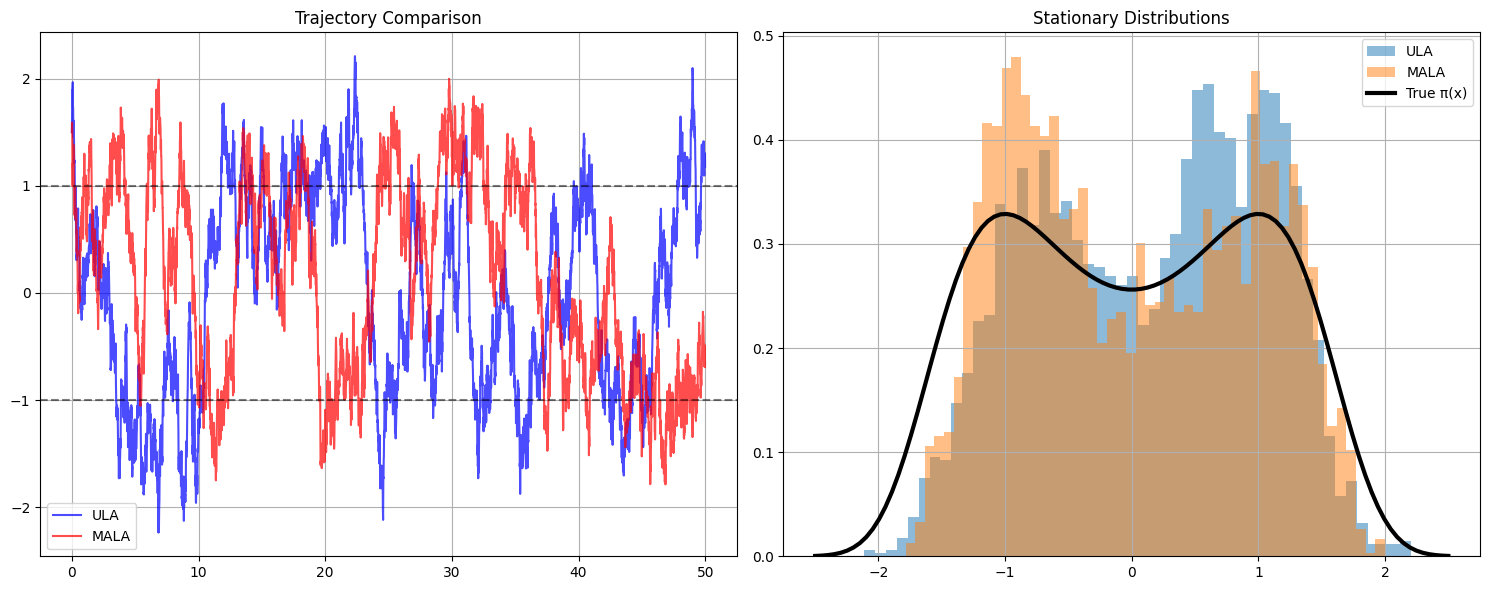

In [14]:
# Generate trajectories
t = np.arange(5000) * 0.01
x_ula = simulate_langevin(method='ula')
x_mala = simulate_langevin(method='mala')

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Trajectories
ax1.plot(t, x_ula, 'b-', alpha=0.7, label='ULA')
ax1.plot(t, x_mala, 'r-', alpha=0.7, label='MALA')
ax1.axhline(-1, color='k', ls='--', alpha=0.5)
ax1.axhline(+1, color='k', ls='--', alpha=0.5)
ax1.set_title('Trajectory Comparison')
ax1.legend()

# Histograms (burn-in removed)
burn = 1000
ax2.hist(x_ula[burn:], bins=50, density=True, alpha=0.5, label='ULA')
ax2.hist(x_mala[burn:], bins=50, density=True, alpha=0.5, label='MALA')
xs = np.linspace(-2.5, 2.5, 100)
target = np.exp(-potential_U(xs))
target /= np.trapz(target, xs)
ax2.plot(xs, target, 'k-', linewidth=3, label='True π(x)')
ax2.set_title('Stationary Distributions')
ax2.legend()

plt.tight_layout()



In [15]:
# Full implementation with diagnostics
def run_langevin_comparison(n_chains=4, n_steps=10000, burn=2000):
    """Run multiple chains for convergence diagnostics"""
    methods = ['ula', 'mala']
    results = {}

    for method in methods:
        chains = []
        for chain in range(n_chains):
            x = simulate_langevin(n_steps, method=method)
            chains.append(x[burn:])
        results[method] = np.array(chains)

    # Effective sample size, autocorrelation, etc.
    return results

# Usage
samples = run_langevin_comparison()



# 2. Bayesian Logistic Regression with Random-Walk MH, ULA, and **MALA**

This notebook demonstrates **gradient-based MCMC** on a Bayesian logistic regression model.

We will:
1. Define the posterior $\pi(\beta)\propto p(y\mid X,\beta)p(\beta)$
2. Define the **potential energy** $U(\beta)=-\log \pi(\beta)$
3. Implement:
   - Random-Walk Metropolis (RW-MH)
   - Unadjusted Langevin Algorithm (ULA) *(biased)*
   - Metropolis-Adjusted Langevin Algorithm (MALA) *(exact)*
4. Compare diagnostics: trace, acceptance rate, autocorrelation, ESS, $\hat R$.

> **Key takeaway:** MALA uses the gradient to propose smarter moves than RW-MH, and the Metropolis correction removes discretization bias.


In [16]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)



## Synthetic dataset

We generate a logistic regression dataset with standardized predictors.


In [17]:

# Synthetic logistic regression data
n = 800
d = 6
X = np.random.normal(size=(n, d))
X = (X - X.mean(axis=0)) / X.std(axis=0)  # standardize

true_beta = np.array([1.2, -1.0, 0.7, 0.0, -0.8, 0.4])
logits = X @ true_beta
p = 1 / (1 + np.exp(-logits))
y = np.random.binomial(1, p, size=n)

print('n, d =', n, d)
print('y mean =', y.mean())


n, d = 800 6
y mean = 0.48375



## Bayesian model and potential energy

Model:
- Likelihood: $y_i\sim\text{Bernoulli}(\sigma(x_i^T\beta))$
- Prior: $\beta\sim\mathcal N(0, \lambda^{-1} I)$

Define:
$
\pi(\beta) \propto p(y\mid\beta)p(\beta),\qquad U(\beta)=-\log\pi(\beta).
$

We also need the gradient $\nabla U(\beta)$ for MALA.

Please note that we used $w$ in the lectures instead of $\beta$.


In [18]:

lambda_prior = 1.0  # prior precision

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# log posterior up to additive constant: log p(y|beta) + log p(beta)
def log_post(beta):
    z = X @ beta
    # stable log-likelihood using softplus
    ll = np.sum(y * (-np.logaddexp(0, -z)) + (1 - y) * (-np.logaddexp(0, z)))
    lp = -0.5 * lambda_prior * np.dot(beta, beta)
    return ll + lp

# gradient of log posterior

def grad_log_post(beta):
    z = X @ beta
    s = sigmoid(z)
    grad_ll = X.T @ (y - s)
    grad_lp = -lambda_prior * beta
    return grad_ll + grad_lp

# potential energy and gradient

def U(beta):
    return -log_post(beta)

def grad_U(beta):
    return -grad_log_post(beta)

# quick sanity check: finite-difference gradient test
beta_test = np.random.normal(size=d)

eps = 1e-5
fd = np.zeros(d)
for j in range(d):
    e = np.zeros(d)
    e[j] = 1
    fd[j] = (U(beta_test + eps*e) - U(beta_test - eps*e)) / (2*eps)

print('max |grad_U - fd| =', np.max(np.abs(grad_U(beta_test) - fd)))


max |grad_U - fd| = 1.1903352969966363e-08



## Diagnostics: autocorrelation, ESS, $\hat R$

We implement lightweight versions of:
- ACF (autocorrelation function)
- ESS (effective sample size)
- $\hat R$ (Gelman--Rubin) across multiple chains


In [19]:

def autocorr_1d(x, max_lag=100):
    x = np.asarray(x)
    x = x - x.mean()
    n = len(x)
    var = np.dot(x, x) / n
    ac = np.empty(max_lag + 1)
    ac[0] = 1.0
    for k in range(1, max_lag + 1):
        ac[k] = np.dot(x[:-k], x[k:]) / (n - k) / var
    return ac


def ess_1d(x, max_lag=400):
    ac = autocorr_1d(x, max_lag=max_lag)
    s = 0.0
    for k in range(1, len(ac)):
        if ac[k] <= 0:
            break
        s += ac[k]
    n = len(x)
    return n / (1 + 2*s)


def rhat(chains):
    # chains shape: (m, n)
    chains = np.asarray(chains)
    m, n = chains.shape
    chain_means = chains.mean(axis=1)
    B = n * np.var(chain_means, ddof=1)
    W = np.mean(np.var(chains, axis=1, ddof=1))
    var_hat = (n - 1) / n * W + B / n
    return np.sqrt(var_hat / W)



## Samplers

### 4.1 Random-Walk Metropolis (RW-MH)
Proposal: $\beta^* = \beta + \sigma\,\xi$.

### 4.2 ULA (biased)
Euler discretization of Langevin diffusion:
$
\beta_{k+1} = \beta_k + \tfrac{\epsilon}{2}\,\nabla\log\pi(\beta_k) + \sqrt{\epsilon}\,z_k.
$
Without Metropolis correction, the stationary distribution is generally **not** exactly $\pi$.

### 4.3 MALA (exact)
Same proposal as ULA, but with MH acceptance:
$
\alpha = \min\left(1,\; \frac{\pi(\beta^*)\,q(\beta\mid\beta^*)}{\pi(\beta)\,q(\beta^*\mid\beta)}\right).
$
Important: the Langevin proposal is **not symmetric** (the mean depends on the gradient), so we must include the proposal-density ratio.


In [20]:

import math

def rw_mh(beta0, n_steps, sigma):
    d = len(beta0)
    chain = np.zeros((n_steps, d))
    chain[0] = beta0
    lp = log_post(beta0)
    acc = 0
    for t in range(1, n_steps):
        prop = chain[t-1] + np.random.normal(scale=sigma, size=d)
        lp_prop = log_post(prop)
        if np.log(np.random.rand()) < (lp_prop - lp):
            chain[t] = prop
            lp = lp_prop
            acc += 1
        else:
            chain[t] = chain[t-1]
    return chain, acc/(n_steps-1)


def ula(beta0, n_steps, step):
    d = len(beta0)
    chain = np.zeros((n_steps, d))
    chain[0] = beta0
    for t in range(1, n_steps):
        g = grad_log_post(chain[t-1])
        chain[t] = chain[t-1] + 0.5*step*g + np.random.normal(scale=math.sqrt(step), size=d)
    return chain


def log_norm_density(x, mean, var):
    diff = x - mean
    d = len(x)
    return -0.5*(d*np.log(2*np.pi*var) + np.dot(diff, diff)/var)


def mala(beta0, n_steps, step):
    d = len(beta0)
    chain = np.zeros((n_steps, d))
    chain[0] = beta0

    lp = log_post(beta0)
    g = grad_log_post(beta0)

    var = step
    sqrt_var = math.sqrt(var)
    acc = 0

    for t in range(1, n_steps):
        curr = chain[t-1]

        mean_fwd = curr + 0.5*var*g
        prop = mean_fwd + np.random.normal(scale=sqrt_var, size=d)

        lp_prop = log_post(prop)
        g_prop = grad_log_post(prop)

        mean_rev = prop + 0.5*var*g_prop

        log_q_fwd = log_norm_density(prop, mean_fwd, var)
        log_q_rev = log_norm_density(curr, mean_rev, var)

        log_alpha = (lp_prop - lp) + (log_q_rev - log_q_fwd)

        if np.log(np.random.rand()) < min(0.0, log_alpha):
            chain[t] = prop
            lp = lp_prop
            g = g_prop
            acc += 1
        else:
            chain[t] = curr

    return chain, acc/(n_steps-1)



## Run experiments and compare

We tune parameters so that:
- RW-MH acceptance is around 0.2--0.3
- MALA acceptance is around 0.4--0.6

Then we compare trace, ACF, ESS, and $\hat R$.


In [21]:

np.random.seed(2026)

n_steps = 12000
burn = 3000
m = 3

rw_sigma = 0.10
mala_step = 0.015
ula_step = 0.015

# run multiple chains
chains_rw = []
chains_mala = []
chains_ula = []
acc_rw = []
acc_mala = []

for i in range(m):
    beta0 = np.random.normal(scale=0.5, size=d)

    ch_rw, ar_rw = rw_mh(beta0, n_steps, rw_sigma)
    ch_mala, ar_mala = mala(beta0, n_steps, mala_step)
    ch_ula = ula(beta0, n_steps, ula_step)

    chains_rw.append(ch_rw)
    chains_mala.append(ch_mala)
    chains_ula.append(ch_ula)

    acc_rw.append(ar_rw)
    acc_mala.append(ar_mala)

chains_rw = np.array(chains_rw)
chains_mala = np.array(chains_mala)
chains_ula = np.array(chains_ula)

print('Acceptance RW-MH:', np.mean(acc_rw))
print('Acceptance MALA :', np.mean(acc_mala))


Acceptance RW-MH: 0.23821429563574745
Acceptance MALA : 0.49020751729310774



### Summary metrics

We compute:
- $\hat R$ (max across coefficients)
- average ESS across coefficients


In [22]:


def summarize(chains):
    # chains: m x n x d
    post = chains[:, burn:, :]
    rh = []
    ess = []
    for j in range(d):
        rh.append(rhat(post[:,:,j]))
        ess.append(np.mean([ess_1d(post[i,:,j]) for i in range(post.shape[0])]))
    return np.array(rh), np.array(ess)

rh_rw, ess_rw = summarize(chains_rw)
rh_mala, ess_mala = summarize(chains_mala)
rh_ula, ess_ula = summarize(chains_ula)

print('RW-MH  max Rhat:', rh_rw.max(), 'avg ESS:', ess_rw.mean())
print('MALA   max Rhat:', rh_mala.max(), 'avg ESS:', ess_mala.mean())
print('ULA    max Rhat:', rh_ula.max(), 'avg ESS:', ess_ula.mean())


RW-MH  max Rhat: 1.0014679264907016 avg ESS: 395.53104495389175
MALA   max Rhat: 1.0006459319691314 avg ESS: 2166.30388808251
ULA    max Rhat: 1.00012222308078 avg ESS: 5419.116904690932



## Plots

We show:
- Trace for one coefficient
- Histogram vs each method
- Autocorrelation and ESS

(ULA is included to illustrate how discretization can change behavior when there is no MH correction.)


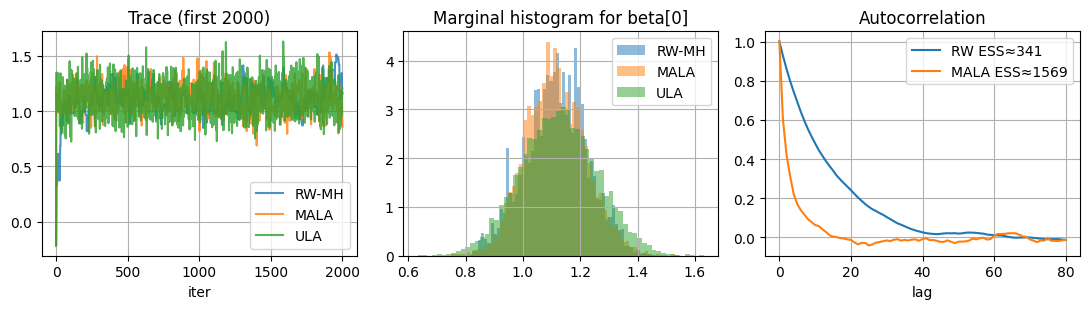

In [23]:

# pick coefficient j and chain i
j = 0
i = 0

rw = chains_rw[i, burn:, j]
mala_ = chains_mala[i, burn:, j]
ula_ = chains_ula[i, burn:, j]

plt.figure(figsize=(11,3.2))
plt.subplot(1,3,1)
plt.plot(chains_rw[i,:2000,j], label='RW-MH', alpha=0.8)
plt.plot(chains_mala[i,:2000,j], label='MALA', alpha=0.8)
plt.plot(chains_ula[i,:2000,j], label='ULA', alpha=0.8)
plt.title('Trace (first 2000)')
plt.xlabel('iter')
plt.legend()

plt.subplot(1,3,2)
plt.hist(rw, bins=60, density=True, alpha=0.5, label='RW-MH')
plt.hist(mala_, bins=60, density=True, alpha=0.5, label='MALA')
plt.hist(ula_, bins=60, density=True, alpha=0.5, label='ULA')
plt.title(f'Marginal histogram for beta[{j}]')
plt.legend()

plt.subplot(1,3,3)
ac_rw = autocorr_1d(rw, max_lag=80)
ac_mala = autocorr_1d(mala_, max_lag=80)
plt.plot(ac_rw, label=f'RW ESS≈{ess_1d(rw):.0f}')
plt.plot(ac_mala, label=f'MALA ESS≈{ess_1d(mala_):.0f}')
plt.title('Autocorrelation')
plt.xlabel('lag')
plt.legend()

plt.tight_layout()
plt.show()



## Conclusion
- **RW-MH**: often good acceptance but can move slowly (random-walk diffusion).
- **ULA**: can move fast, but its stationary distribution is generally not exactly $\pi$ for fixed step size (discretization bias).
- **MALA**: keeps the gradient-based proposal but uses MH correction to target the exact posterior.



## Acknowledgements/ Document preparation
This code was developed with assistance from ChatGPT (OpenAI) and CoPilot (Microsoft). The instructor modified the text and code and verified the final results and wording.
